In [1]:
import pandas as pd
import os
import torch
import time
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import *

%matplotlib inline

In [2]:
batch_size = 400
epochs = 120
max_lr = 0.001
grad_clip = 0.01
weight_decay =0.001
opt_func = torch.optim.Adam

In [14]:
train_data = torchvision.datasets.CIFAR100('./', train=True, download=True)

# Stick all the images together to form a 1600000 X 32 X 3 array
x = np.concatenate([np.asarray(train_data[i][0]) for i in range(len(train_data))])

# calculate the mean and std along the (0, 1) axes
mean = np.mean(x, axis=(0, 1))/255
std = np.std(x, axis=(0, 1))/255
# the the mean and std
mean=mean.tolist()
std=std.tolist()
print(mean)
print(std)

Files already downloaded and verified
[0.5070751592371323, 0.48654887331495095, 0.4409178433670343]
[0.26733428587941854, 0.25643846292120615, 0.2761504713263903]


In [4]:
transform_train = tt.Compose([tt.RandomCrop(32, padding=4,padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(mean,std,inplace=True)])
transform_test = tt.Compose([tt.ToTensor(), tt.Normalize(mean,std)])

In [5]:
trainset = torchvision.datasets.CIFAR100("./",
                                         train=True,
                                         download=True,
                                         transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size, shuffle=True, num_workers=2,pin_memory=True)

testset = torchvision.datasets.CIFAR100("./",
                                        train=False,
                                        download=True,
                                        transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size*2,pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Device check and load model into device

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()
device

device(type='cuda')

In [8]:
trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

# Layer Setup

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1028, pool=True) 
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028 
                                        nn.Linear(1028, num_classes)) # 1028 -> 100
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

model = to_device(ResNet9(3, 100), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

# Training Setup

In [10]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, test_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [15]:
# Initial evaluation
history = [evaluate(model, testloader)]
history

[{'val_loss': 0.9812536835670471, 'val_acc': 0.7433654069900513}]

In [12]:
# Fitting the first 1/4 epochs
current_time=time.time()
history += fit_one_cycle(int(epochs/4), max_lr, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00007, train_loss: 3.6366, val_loss: 3.1101, val_acc: 0.2449
Epoch [1], last_lr: 0.00015, train_loss: 2.9111, val_loss: 2.7657, val_acc: 0.3062
Epoch [2], last_lr: 0.00028, train_loss: 2.5651, val_loss: 2.5890, val_acc: 0.3393
Epoch [3], last_lr: 0.00044, train_loss: 2.3236, val_loss: 2.6218, val_acc: 0.3495
Epoch [4], last_lr: 0.00060, train_loss: 2.1064, val_loss: 2.2853, val_acc: 0.4133
Epoch [5], last_lr: 0.00076, train_loss: 1.9243, val_loss: 2.3465, val_acc: 0.3966
Epoch [6], last_lr: 0.00089, train_loss: 1.7575, val_loss: 2.4585, val_acc: 0.3906
Epoch [7], last_lr: 0.00097, train_loss: 1.6301, val_loss: 2.1428, val_acc: 0.4575
Epoch [8], last_lr: 0.00100, train_loss: 1.5111, val_loss: 2.0869, val_acc: 0.4673
Epoch [9], last_lr: 0.00099, train_loss: 1.3806, val_loss: 2.1153, val_acc: 0.4615
Epoch [10], last_lr: 0.00098, train_loss: 1.2796, val_loss: 1.6648, val_acc: 0.5442
Epoch [11], last_lr: 0.00095, train_loss: 1.1885, val_loss: 2.0127, val_acc: 0.4876
Ep

In [13]:
# Fitting the second 1/4 epochs
history += fit_one_cycle(int(epochs/4), max_lr/10, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 0.0444, val_loss: 0.9924, val_acc: 0.7456
Epoch [1], last_lr: 0.00002, train_loss: 0.0438, val_loss: 1.0000, val_acc: 0.7436
Epoch [2], last_lr: 0.00003, train_loss: 0.0428, val_loss: 1.0238, val_acc: 0.7408
Epoch [3], last_lr: 0.00004, train_loss: 0.0459, val_loss: 1.0489, val_acc: 0.7374
Epoch [4], last_lr: 0.00006, train_loss: 0.0527, val_loss: 1.0789, val_acc: 0.7303
Epoch [5], last_lr: 0.00008, train_loss: 0.0681, val_loss: 1.1334, val_acc: 0.7170
Epoch [6], last_lr: 0.00009, train_loss: 0.0822, val_loss: 1.1806, val_acc: 0.7131
Epoch [7], last_lr: 0.00010, train_loss: 0.0948, val_loss: 1.1704, val_acc: 0.7121
Epoch [8], last_lr: 0.00010, train_loss: 0.0967, val_loss: 1.2975, val_acc: 0.6908
Epoch [9], last_lr: 0.00010, train_loss: 0.0910, val_loss: 1.2027, val_acc: 0.7029
Epoch [10], last_lr: 0.00010, train_loss: 0.0825, val_loss: 1.2248, val_acc: 0.7035
Epoch [11], last_lr: 0.00010, train_loss: 0.0719, val_loss: 1.1945, val_acc: 0.7071
Ep

In [14]:

history += fit_one_cycle(int(epochs/8), max_lr/100, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00000, train_loss: 0.0084, val_loss: 1.0526, val_acc: 0.7467
Epoch [1], last_lr: 0.00000, train_loss: 0.0079, val_loss: 1.0536, val_acc: 0.7460
Epoch [2], last_lr: 0.00001, train_loss: 0.0085, val_loss: 1.0602, val_acc: 0.7457
Epoch [3], last_lr: 0.00001, train_loss: 0.0092, val_loss: 1.0587, val_acc: 0.7458
Epoch [4], last_lr: 0.00001, train_loss: 0.0095, val_loss: 1.0599, val_acc: 0.7439
Epoch [5], last_lr: 0.00001, train_loss: 0.0091, val_loss: 1.0549, val_acc: 0.7449
Epoch [6], last_lr: 0.00001, train_loss: 0.0090, val_loss: 1.0496, val_acc: 0.7437
Epoch [7], last_lr: 0.00001, train_loss: 0.0084, val_loss: 1.0490, val_acc: 0.7458
Epoch [8], last_lr: 0.00001, train_loss: 0.0083, val_loss: 1.0472, val_acc: 0.7457
Epoch [9], last_lr: 0.00000, train_loss: 0.0084, val_loss: 1.0454, val_acc: 0.7461
Epoch [10], last_lr: 0.00000, train_loss: 0.0075, val_loss: 1.0437, val_acc: 0.7468
Epoch [11], last_lr: 0.00000, train_loss: 0.0071, val_loss: 1.0413, val_acc: 0.7482
Ep

In [15]:

history += fit_one_cycle(int(epochs/8), max_lr/1000, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00000, train_loss: 0.0067, val_loss: 1.0394, val_acc: 0.7483
Epoch [1], last_lr: 0.00000, train_loss: 0.0067, val_loss: 1.0410, val_acc: 0.7476
Epoch [2], last_lr: 0.00000, train_loss: 0.0070, val_loss: 1.0413, val_acc: 0.7472
Epoch [3], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0426, val_acc: 0.7472
Epoch [4], last_lr: 0.00000, train_loss: 0.0068, val_loss: 1.0400, val_acc: 0.7473
Epoch [5], last_lr: 0.00000, train_loss: 0.0069, val_loss: 1.0395, val_acc: 0.7476
Epoch [6], last_lr: 0.00000, train_loss: 0.0068, val_loss: 1.0410, val_acc: 0.7464
Epoch [7], last_lr: 0.00000, train_loss: 0.0066, val_loss: 1.0398, val_acc: 0.7468
Epoch [8], last_lr: 0.00000, train_loss: 0.0067, val_loss: 1.0396, val_acc: 0.7468
Epoch [9], last_lr: 0.00000, train_loss: 0.0064, val_loss: 1.0403, val_acc: 0.7473
Epoch [10], last_lr: 0.00000, train_loss: 0.0065, val_loss: 1.0390, val_acc: 0.7468
Epoch [11], last_lr: 0.00000, train_loss: 0.0067, val_loss: 1.0397, val_acc: 0.7478
Ep

In [16]:

history += fit_one_cycle(int(epochs/4), max_lr/100, model, trainloader, testloader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)
# Print training time
print('Training time: {:.2f} s'.format(time.time() - current_time))

Epoch [0], last_lr: 0.00000, train_loss: 0.0068, val_loss: 1.0398, val_acc: 0.7472
Epoch [1], last_lr: 0.00000, train_loss: 0.0066, val_loss: 1.0417, val_acc: 0.7468
Epoch [2], last_lr: 0.00000, train_loss: 0.0070, val_loss: 1.0412, val_acc: 0.7470
Epoch [3], last_lr: 0.00000, train_loss: 0.0068, val_loss: 1.0396, val_acc: 0.7468
Epoch [4], last_lr: 0.00001, train_loss: 0.0070, val_loss: 1.0435, val_acc: 0.7453
Epoch [5], last_lr: 0.00001, train_loss: 0.0078, val_loss: 1.0409, val_acc: 0.7467
Epoch [6], last_lr: 0.00001, train_loss: 0.0080, val_loss: 1.0403, val_acc: 0.7437
Epoch [7], last_lr: 0.00001, train_loss: 0.0085, val_loss: 1.0511, val_acc: 0.7430
Epoch [8], last_lr: 0.00001, train_loss: 0.0090, val_loss: 1.0448, val_acc: 0.7456
Epoch [9], last_lr: 0.00001, train_loss: 0.0090, val_loss: 1.0444, val_acc: 0.7453
Epoch [10], last_lr: 0.00001, train_loss: 0.0088, val_loss: 1.0379, val_acc: 0.7457
Epoch [11], last_lr: 0.00001, train_loss: 0.0087, val_loss: 1.0396, val_acc: 0.7457
Ep

# Prediction

In [17]:
# Collect training time and result
current_time = time.time()
result = evaluate(model, testloader)
result
print('Training time: {:.2f} s'.format(time.time() - current_time))

Training time: 2.46 s


In [18]:
# Saving the model to h5 file
torch.save(model.state_dict(), 'group22_pretrained_model.h5')

In [19]:
# Generate testing accuracy, predicted label, confusion matrix, and table for classification report
def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

y_test, y_pred = test_label_predictions(model, device, testloader)
cm=confusion_matrix(y_test, y_pred)
cr=classification_report(y_test, y_pred)
fs=f1_score(y_test,y_pred,average='weighted')
rs=recall_score(y_test, y_pred,average='weighted')
accuracy=accuracy_score(y_test, y_pred)
print('Confusion matrix:')
print(cm)
print(cr)
print('F1 score: %f' % fs)
print('Recall score: %f' % rs)
print('Accuracy score: %f' % accuracy)

Confusion matrix:
[[90  0  0 ...  0  1  0]
 [ 0 88  0 ...  0  0  0]
 [ 0  0 62 ...  0  1  0]
 ...
 [ 0  0  0 ... 80  0  0]
 [ 1  0  3 ...  0 62  0]
 [ 0  0  1 ...  0  0 79]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       100
           1       0.84      0.88      0.86       100
           2       0.60      0.62      0.61       100
           3       0.68      0.58      0.63       100
           4       0.56      0.65      0.60       100
           5       0.79      0.76      0.78       100
           6       0.73      0.82      0.77       100
           7       0.79      0.72      0.75       100
           8       0.86      0.88      0.87       100
           9       0.85      0.82      0.83       100
          10       0.64      0.54      0.59       100
          11       0.52      0.55      0.53       100
          12       0.72      0.80      0.76       100
          13       0.76      0.65      0.70       100
          14   

In [20]:
# Save classificationreport into csv
report = classification_report(y_test, y_pred, output_dict = True)
df=pd.DataFrame(report).transpose()
df.to_csv('classificationreport.csv',index=False)

In [21]:
# Plot classification report and save to pdf function
def plot_classification(precision, recall, f1_score):
    plt.rcParams['font.size'] = 12
    plt.rc('axes', linewidth=1.75)
    marker_size = 8
    figsize = 6
    plt.figure(figsize=(1.4 * figsize, figsize))
    plt.subplot(3, 1, 1)
    plt.plot(precision, 'o', markersize=marker_size)
    # plt.legend(loc=0)
    # plt.yticks(np.arange(0.5, 1.01, 0.1))
    plt.ylabel('Precision', fontsize=14)
    plt.xticks([])
    plt.subplot(3, 1, 2)
    plt.plot(recall, 'o', markersize=marker_size)
    # plt.yticks(np.arange(0.5, 1.01, 0.1))
    plt.ylabel('Recall', fontsize=14)
    plt.xticks([])
    plt.subplot(3, 1, 3)
    plt.plot(f1_score, 'o', markersize=marker_size)
    # plt.yticks(np.arange(0.5, 1.01, 0.1))
    plt.ylabel('F1-score', fontsize=14)
    plt.xlabel('Class', fontsize=14)
    plt.subplots_adjust(hspace=0.001)
    plt.tight_layout()
    plt.savefig("classification.pdf")


In [22]:
# Plot classification report and save to pdf
def plot_confusion_matrix(cm):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.colorbar()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.tight_layout()
    plt.savefig("confusion_matrix.pdf")
    plt.show()

In [23]:
# Obtain training accuracy
y_train, y_pred2 = test_label_predictions(model, device, trainloader)
train_accuracy=accuracy_score(y_train, y_pred2)
print('Train accuracy: %f' % train_accuracy)

Train accuracy: 0.999760


[0.9  0.88 0.62 0.58 0.65 0.76 0.82 0.72 0.88 0.82 0.54 0.55 0.8  0.65
 0.74 0.85 0.75 0.87 0.65 0.62 0.86 0.89 0.72 0.84 0.85 0.63 0.74 0.62
 0.81 0.71 0.7  0.72 0.67 0.66 0.76 0.53 0.85 0.8  0.62 0.84 0.68 0.88
 0.74 0.82 0.48 0.67 0.48 0.7  0.93 0.88 0.63 0.74 0.67 0.88 0.88 0.5
 0.93 0.79 0.86 0.66 0.88 0.71 0.81 0.74 0.59 0.65 0.81 0.71 0.93 0.81
 0.76 0.86 0.51 0.58 0.57 0.9  0.89 0.74 0.67 0.82 0.62 0.8  0.91 0.74
 0.71 0.85 0.73 0.86 0.8  0.9  0.85 0.83 0.66 0.65 0.96 0.73 0.66 0.8
 0.62 0.79]


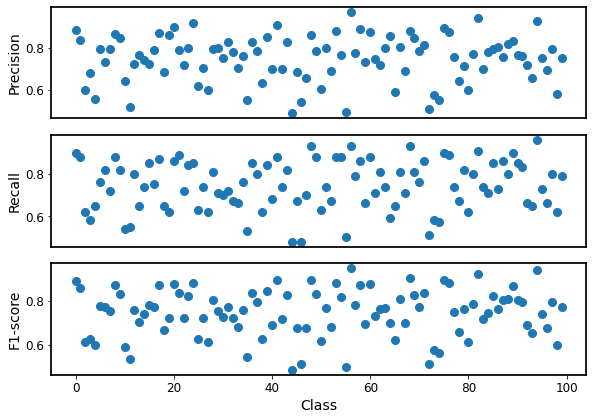

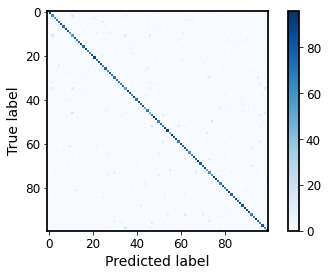

In [24]:
# Plot and save confusion matrix
precision, recall, f1,_= precision_recall_fscore_support(y_test, y_pred)
print(recall)
plot_classification(precision, recall, f1)

# Plot confusion matrix
plot_confusion_matrix(cm)